In [ ]:
# 패키지 임포트
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 데이터 세트 표준
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [ ]:
# 데이터 세트 셰이프 확인
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape
# 훈련용 5만개, 테스트용 만개
# 칼라이미지라서 채널값이 3

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

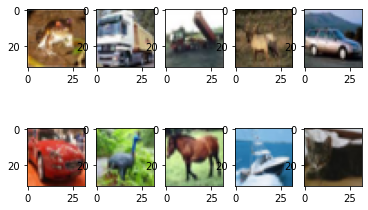

In [ ]:
# 데이터 세트 이미지 확인
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i])
plt.show()

In [ ]:
# 데이터 세트 라벨 확인
train_labels[0:10]
# 범주형 변수로 정의되어 있음 => 원핫 인코딩으로 변환 처리

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

In [ ]:
# 데이터 세트 전처리 -> 원핫인코딩
train_labels = to_categorical(train_labels)
test_labels  = to_categorical(test_labels)

In [ ]:
# 데이터 세트 전처리 후 셰이프 확인
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [ ]:
# 원-핫인코딩 처리 확인
train_labels[0:10]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [27]:
# 컨볼루셔널 레이어 생성
def conv(filters, kernel_size, strides=1):
    return Conv2D(filters,                        # 커널수, int
                  kernel_size,                    # 커널 사이즈, int or tuple
                  strides=strides,                # 스트라이드,  int or tuple
                  padding='same',                 # 패딩, 입력사이즈와같은 사이즈 same, 아니면 vaild
                  use_bias=False,                 # 바이어스 추가 여부
                  kernel_initializer='he_normal', # 커널 가중치(weight) 행렬의 초기값, he_normal:정규분포에 따른 초기값
                  kernel_regularizer=l2(0.0001)   # kernel의 가중치에 적용할 정규화 l2는 L2 정규화
                  )
'''
가중치 초기화 방법을 따로 설정해 주지 않으면 기본적으로 케라스 레이어의 가중치 초기화 방식은
일정 구간 내에서 랜덤하게 찍는 random_uniform이다. 
하지만 이러한 방식은 오차 역전파(back propagation) 과정에서 미분한 gradient가 
지나치게 커지거나(exploding gradient) 소실되는(vanishing gradient) 문제에
빠질 위험성이 크다

어떻게 가중치를 초기화할 것인가에 대한 지속적인 연구가 진행되어 왔고, 
이전에 비해 개선된 초기화 방식이 제안되었으며 널리 활용되고 있다. 
케라스에서 제공하는 초기화 방식 중 흔히 사용되는 것들은 다음과 같다.

LeCun 초기화(lecun_uniform, lecun_normal): 
  - 98년도에 얀 르쿤이 제기한 방법으로 최근에는 Xavier나 He 초기화 방식에 비해 덜 사용되는 편이다.

Xavier 초기화(glorot_uniform, glorot_normal): 
  - 케라스에서는 glorot이라는 이름으로 되어있는데, 
  - 일반적으로는 Xavier Initialization이라고 알려져 있다. 
  - 사실 초기화 방식이 제안된 논문의 1저자 이름이 Xavier Glorot이다(출처). 2저자는 유명한 Yoshua Bengio.

He 초기화(he_uniform, he_normal): 
  - ResNet으로도 유명한 마이크로소프트(현재는 Facebook)의 Kaiming He가 2015년에 제안한 가장 최신의 초기화 방식이다. 
  = 수식을 보면 Xavier Initialization을 조금 개선한 것인데, 경험적으로 더 좋은 결과를 내었다고 한다.
'''
'''
정규화(Regularization)
  - 모델을 복잡하게 하는 가중치에, 가중치 양만큼 패널티를 부여하여 모델이 복잡해지지 않도록 하게함
  - L1 정규화 : 극단적인 가중치를 0으로함
  - L2 정규화 : 극단적인 가중치를 0에 가깝게 함
  - 계수(위에서는 0.0001:패널티비율)

https://light-tree.tistory.com/125 참고
과대적합, 과소적합에 대한 해결책 : L1 Regularization 과 L2 Regularization 
보통 번역은 '정규화' 라고 하지만 '일반화' 라고 하는 것이 이해에는 더 도움이 될 수도 있습니다. 
모델 복잡도에 대한 패널티로 정규화는 Overfitting 을 예방하고 Generalization(일반화) 
성능을 높이는데 도움을 줍니다. Regularization 방법으로는 
L1 Regularization, L2 Regularization, Dropout, Early stopping

- L1
  L1의 경우에는 가중치의 크기에 상관없이 상수값을 뺀다. 
  이는 대체적으로 불필요한 가중치의 수치를 0으로 만들도록 하는 방향으로 적용됩니다.   
  즉, 중요한 가중치만을 취하기 때문에 sparse feature에 대한 모델을 구성하는데 적합
- L2
​ L2의 경우에는 가중치의 값을 이용합니다. 어느 정도 튀는 값에 대해 대응할 수 있다. 
 따라서, 이상치나 노이즈가 있는 데이터에 대한 학습을 진행할 때 사용하면 좋다. 
 특히 선형 모델의 일반화에 좋다  
 가중치를 작아지는 방향으로 진행하여 가중치의 비정상적인 성장을 막고 최종적으로 학습에 영향을 올바르게 할 수 있도록 도와줍
'''

'\nhttps://light-tree.tistory.com/125\n과대적합, 과소적합에 대한 해결책 : L1 Regularization 과 L2 Regularization \n- L1\n  L1의 경우에는 가중치의 크기에 상관없이 상수값을 뺀다. \n  이는 대체적으로 불필요한 가중치의 수치를 0으로 만들도록 하는 방향으로 적용됩니다.   \n  즉, 중요한 가중치만을 취하기 때문에 sparse feature에 대한 모델을 구성하는데 적합\n- L2\n\u200b L2의 경우에는 가중치의 값을 이용합니다. 어느 정도 튀는 값에 대해 대응할 수 있다. \n 따라서, 이상치나 노이즈가 있는 데이터에 대한 학습을 진행할 때 사용하면 좋다. \n 특히 선형 모델의 일반화에 좋다  \n 가중치를 작아지는 방향으로 진행하여 가중치의 비정상적인 성장을 막고 최종적으로 학습에 영향을 올바르게 할 수 있도록 도와줍\n'

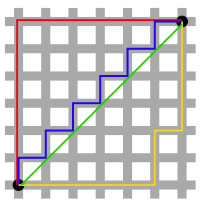

In [33]:
from IPython.display import Image
Image('/content/drive/My Drive/izone/책소스/알파제로를분석하며배우는인공지능/3_deep_learning/L1_L2정규화차이3.png')
# 초록색이 L2, 노랑색이 L1

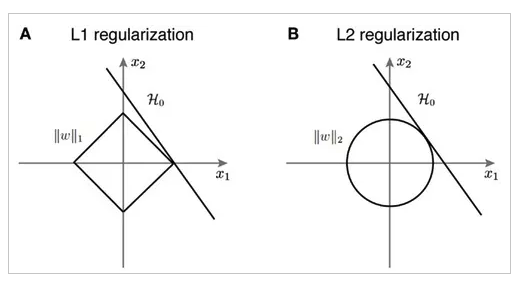

In [26]:
Image('/content/drive/My Drive/izone/책소스/알파제로를분석하며배우는인공지능/3_deep_learning/L1_L2정규화차이2.png')

# 레지듀얼 블럭 생성

- 숏컷 커넥션의 위치가 다른 2종류의 보틀넷 아키텍쳐 54개 연결

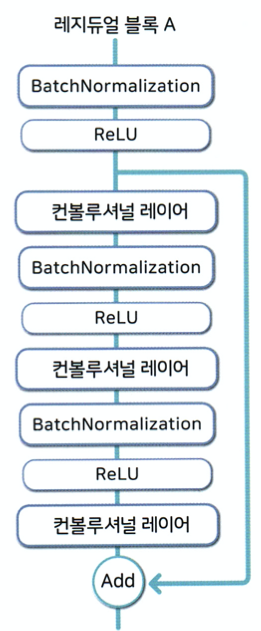

In [35]:
Image('/content/drive/My Drive/izone/책소스/알파제로를분석하며배우는인공지능/3_deep_learning/resnet_레지듀얼블록A.png')
# 구조

In [38]:
16//4, 8//4, 32//4

(4, 2, 8)

In [43]:
# 레지듀얼 블록 A 생성
def first_residual_unit(filters, strides):
  # 클로저 함수
  def f(x):
    # →BN→ReLU
    # BatchNormalization : 학습을 안정시켜서 학습 속도를 높이는 방법
    # conv다음에 연결하여, 컨볼류션 레이어의 출력을 표준화한다
    x = BatchNormalization()(x)
    b = Activation('relu')(x)

    # 컨볼루셔널 레이어→BN→ReLU, 커널크기 1
    x = conv(filters // 4, 1, strides)(b)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 컨볼루셔널 레이어→BN→ReLU, 커널크기 3
    x = conv(filters // 4, 3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 컨볼루셔널 레이어→, 커널크기 1
    x = conv(filters, 1)(x)

    # 숏컷 셰이프 사이즈 조정 -> b에서 바로 sc출력으로 갈수 있다
    sc = conv(filters, 1, strides)(b)

    # Add
    return Add()([x, sc])
  return f

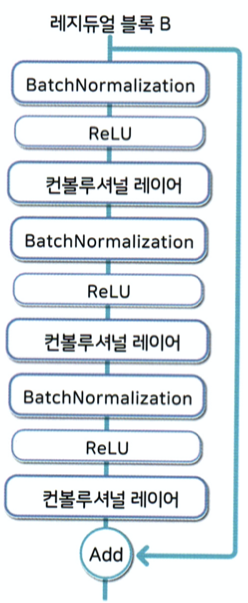

In [42]:
Image('/content/drive/My Drive/izone/책소스/알파제로를분석하며배우는인공지능/3_deep_learning/resnet_레지듀얼블록B.png')
# 구조

In [44]:
# 레지듀얼 블록 B 생성
def residual_unit(filters):
  def f(x):
    # 입력을 바로 sc에 넣어서 맨 마지막에 연결하여 숏컷을 만든다
    sc = x
    
    # →BN→ReLU
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 컨볼루셔널 레이어→BN→ReLU
    x = conv(filters // 4, 1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 컨볼루셔널 레이어→BN→ReLU
    x = conv(filters // 4, 3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 컨볼루셔널 레이어→
    x = conv(filters, 1)(x)

    # Add
    return Add()([x, sc])
  return f

In [46]:
# 레지듀얼 블록 A와 레지듀얼 블록 B x 17 생성
def residual_block(filters, strides, unit_size):
  def f(x):
    # 레지듀얼 블록 A 1개
    x = first_residual_unit(filters, strides)(x)
    # 레지듀얼 블록 B 17개 (18이 들어오면)
    for i in range(unit_size-1):
      x = residual_unit(filters)(x)
    # 연결하여 리턴
    return x
  return f

In [47]:
# 입력
# Sequential을 이용한 네트워크 구성은 분포/다수의 출력을 가진 네트워크 구조를 만들수 없다
# Functional API라는 복잡한 모델을 정의하는 인터페이스를 사용함
# 데이터 1개의 shape은 32x32x3
input = Input(shape=(32,32, 3))

# 컨볼루셔널 레이어
# 커널의 수는 16개, 커널 크기는 3->3x3
x = conv(16, 3)(input)

# 레지듀얼 블록 x 54
# (18개 : 블록 A + 블록 B*17)*3 => 54블록
# 커널크기 64, 스트라이드 1
x = residual_block(64, 1, 18)(x)
# 커널크기 128, 스트라이드 2
x = residual_block(128, 2, 18)(x)
# 커널크기 256, 스트라이드 2
x = residual_block(256, 2, 18)(x)

# →BN→ReLU
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 풀링 레이어
# 가장 많이 사용하는 풀링 기법 : GAP
# CNN + FC에서 FC를 없애기 위해서 도입된 기법 : FC에서 연산양이 많아진다(파라미터가 많아지고, 입력단의 개수가 고정되는 문제
# feature의 위치 정보도 모두 사라짐)
# [참고]https://jetsonaicar.tistory.com/16
# [참고]https://kevinthegrey.tistory.com/142
# 각 feature map 상의 노드값들의 평균을 뽑아낸다.
x = GlobalAveragePooling2D()(x)

# 전결합 레이어
# 최종 출력
output = Dense(10, activation='softmax', kernel_regularizer=l2(0.0001))(x)

# 모델 생성
# 네트워트 전체의 입력과, 출력을 지정한다
model = Model(inputs=input, outputs=output)

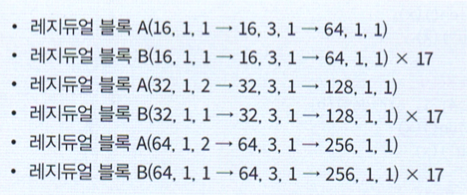

In [34]:
Image('/content/drive/My Drive/izone/책소스/알파제로를분석하며배우는인공지능/3_deep_learning/resnet_레지듀얼블록A_수치.png')
# 수치표, 

In [48]:
# 컴파일
model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['acc'])

In [50]:
# ImageDataGenerator 준비
# 데이터 세트의 이미지의 정규화와 부풀리기(증폭:augmentation) 수행
train_gen  = ImageDataGenerator(
    featurewise_center=True, # 데이터 세트 전체를 대상으로 입력 평균을 0으로 만듬
    featurewise_std_normalization=True, # 입력을 데이터 세트 표준편차로 표준화
    width_shift_range=0.125, # 랜덤으로 수평 이동시킬 범위(비율)
    height_shift_range=0.125,# 랜덤으로 수직 이동시킬 범위(비율) 
    horizontal_flip=True)    # 수평 방향 입력을 랜덤으로 반전
test_gen = ImageDataGenerator(
    featurewise_center=True, # 데이터 세트 전체를 대상으로 입력 평균을 0으로 만듬
    featurewise_std_normalization=True) # 입력을 데이터 세트 표준편차로 표준화

# 데이터 세트 전체 총합량을 미리 계산
for data in (train_gen, test_gen):
  data.fit(train_images)

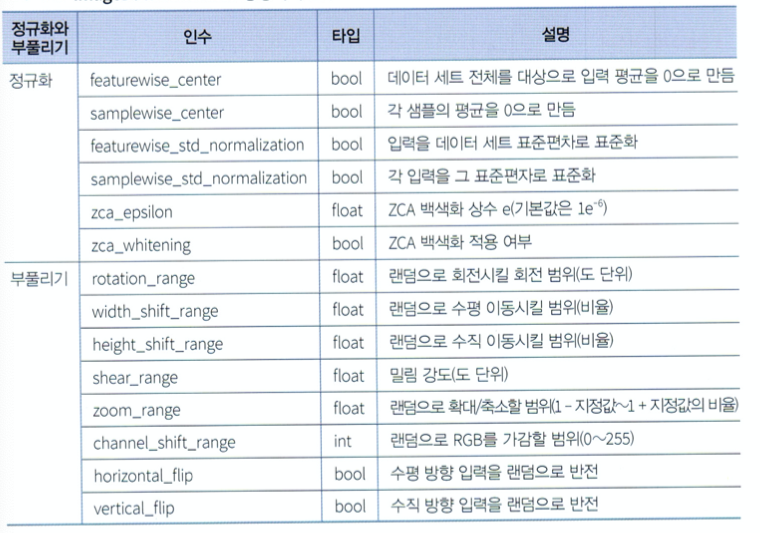

In [51]:
Image('/content/drive/My Drive/izone/책소스/알파제로를분석하며배우는인공지능/3_deep_learning/resnet_이미지증폭.png')

In [53]:
# LearningRateScheduler 준비
# LearningRateScheduler : 학습중 학습률을 변화시키는 콜백이다
# epoch을 인수로 받아서 학습룰을 반환시키는 함수를 생성하고, 해당 함수를 LearningRateScheduler에 전달
def step_decay(epoch):
  # 최초
  x = 0.1
  # 80 이후
  if epoch >= 80: x = 0.01
  # 120 이후
  if epoch >= 120: x = 0.001
  return x
lr_decay = LearningRateScheduler(step_decay)
# 학습률은 각 레이어의 가중치를 한번에 어느 정도 변경할지 결정하는 임계값이다
# 정답에서 멀면 많이, 정답에 가까우면 작게 변경하여 정답에 빠르게 다다를수 있다

In [56]:
batch_size = 128
train_images.shape[0], train_images.shape[0] // batch_size
# 훈련 데이터수 / 배치 사이즈로 지정하면 부풀리기 전과 같은 샘플수를 검증한

(50000, 390)

In [ ]:
# 학습
batch_size = 128
# 학습 이력이 리턴됨
history = model.fit_generator(
    # 훈련 데이터
    train_gen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=100,
    # 이 항목을 지정해야함, validation_steps가 유효함 -> 390
    steps_per_epoch=train_images.shape[0] // batch_size,
    # 검증 데이터 => generator
    validation_data=test_gen.flow(test_images, test_labels, batch_size=batch_size),
    # 검증 1회당 이폭수 -> 390
    validation_steps=test_images.shape[0] // batch_size,
    # 훈련시 콜백함수
    callbacks=[lr_decay])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
149/390 [==========>...................] - ETA: 2:07 - loss: 4.8597 - acc: 0.2951

KeyboardInterrupt: ignored

In [ ]:
# 모델 저장
model.save('resnet.h5')

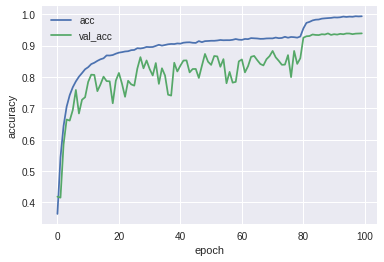

In [ ]:
# 그래프 표시
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [ ]:
# 평가
batch_size = 128
test_loss, test_acc = model.evaluate_generator(
    test_gen.flow(test_images, test_labels, batch_size=batch_size),
    steps=10)
print('loss: {:.3f}\nacc: {:.3f}'.format(test_loss, test_acc ))
# loss:0.450
# acc :0.942

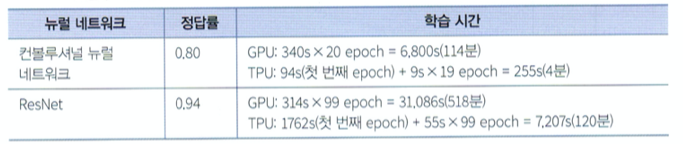

In [57]:
Image('/content/drive/My Drive/izone/책소스/알파제로를분석하며배우는인공지능/3_deep_learning/resnet_평가.png')
# 

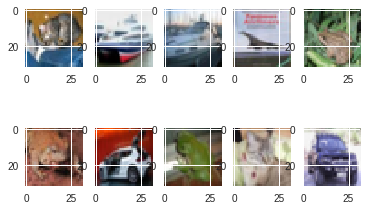

['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']


In [ ]:
# 추론할 이미지 표시
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i])
plt.show()

# 추론한 라벨 표시
test_predictions = model.predict_generator(
    test_gen.flow(test_images[0:10], shuffle = False, batch_size=1),
    steps=10)
test_predictions = np.argmax(test_predictions, axis=1)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
        'dog', 'frog', 'horse', 'ship', 'truck']
print([labels[n] for n in test_predictions])